In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented_dataset.csv


In [2]:
import pandas as pd

In [3]:
# let's store the csv dataset into a DataFrame and have a look at it
# Ссылка на скачивание данных в формате CSV
csv_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3Wns_gLiMDfacVgF-x4suNvnAFmgibVkrsizkKqwcVFGSYAVOVnJsoV7gm3jguw/pub?gid=681978523&single=true&output=csv"

# Загрузка данных в DataFrame
data = pd.read_csv(csv_data_url)

# Просмотр первых нескольких строк данных
print(data.head())

   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs  


In [4]:
# Lets count duplicated entries in the problem_text column
# 'problem_text' имя столбца, в котором нужно найти дубликаты
duplicates = data.duplicated(subset=['problem_text'], keep=False)

# Считаем количество дубликатов
num_duplicates = duplicates.sum()

# Выводим количество дубликатов
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')


Количество дубликатов в столбце "problem_text": 1720


In [5]:
# We'll leave the first entries and we'll drop the duplicates 
# Удаляем дубликаты, оставляя только первые вхождения
data_no_dupes = data.drop_duplicates(subset=['problem_text'], keep='first')

# Перезаписываем индексы после удаления дубликатов
data_no_dupes.reset_index(drop=True, inplace=True)


In [6]:
# We need to check the results. We expect 0 duplicated entries in the column we cleaned
#смотрим, как удалили 
duplicates = data_no_dupes.duplicated(subset=['problem_text'], keep=False)
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 0


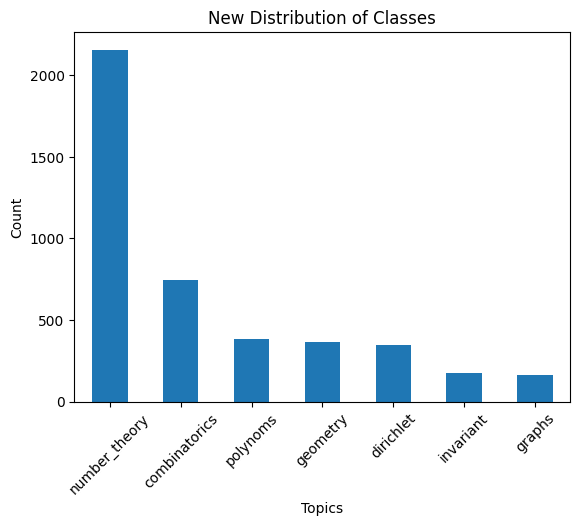

In [7]:
# A quick visual aid to check the distribution over classes
# распределение по классам
import matplotlib.pyplot as plt

class_counts = data_no_dupes['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [8]:
class_counts

topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64

In [9]:
# We'll need to augment the datset to balance the distribution 
# but beforehand we should split the data set into test train val sets 
#разобьем на test train val
from sklearn.model_selection import train_test_split

# Разделение датасета
train, test_val = train_test_split(data_no_dupes, test_size=0.4, random_state=42)
val, test = train_test_split(test_val, test_size=0.5, random_state=42)

# сохраним
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)


In [10]:
!ls -la /kaggle/working

total 1084
drwxr-xr-x 3 root root   4096 May 19 13:41 .
drwxr-xr-x 5 root root   4096 May 19 13:40 ..
drwxr-xr-x 2 root root   4096 May 19 13:40 .virtual_documents
-rw-r--r-- 1 root root 221816 May 19 13:41 test.csv
-rw-r--r-- 1 root root 645934 May 19 13:41 train.csv
-rw-r--r-- 1 root root 221225 May 19 13:41 val.csv


In [11]:
train.head()

,Unnamed: 0,problem_text,topic
2659,3017,What numbers should be put instead of stars to...,number_theory
1613,1745,"In the town of Little 15 phones, can they be w...",combinatorics
835,868,Prove that the number is divided by 2k and not...,number_theory
1405,1497,What is the greatest amount of (a) okay; (b) i...,invariant
4026,4823,"Are there such natural numbers a, b and c that...",polynoms


In [12]:
# We'll augment the train set with https://github.com/makcedward/nlpaug 
# будем выравнивать датасет по классам с помощью https://github.com/makcedward/nlpaug 
!pip install nlpaug numpy matplotlib python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.4 MB/s eta 0:00:00:00:01


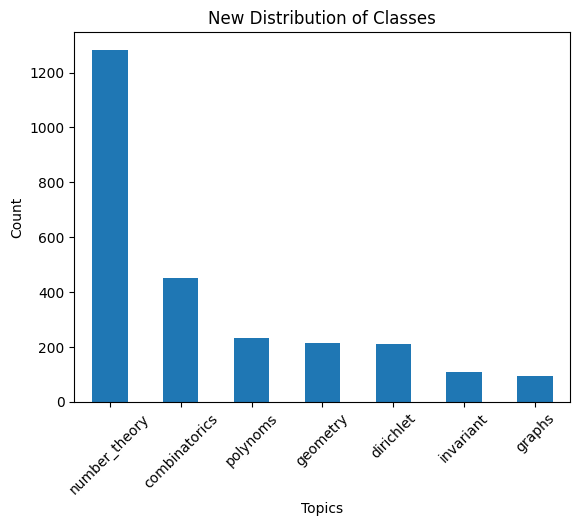

In [13]:
# Lets see how the classes are represented in our train set
import matplotlib.pyplot as plt

class_counts = train['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [14]:
class_counts

topic
number_theory    1284
combinatorics     451
polynoms          231
geometry          212
dirichlet         211
invariant         109
graphs             93
Name: count, dtype: int64

In [15]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


In [16]:
# for Kaggle & Bert tokenizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [17]:
!nvidia-smi

Sun May 19 13:41:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

print('ok')

ok


In [19]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [20]:
# actual augmenting happens here

import nlpaug.augmenter.word as naw
import pandas as pd
import torch
torch.set_printoptions(profile="full")

torch.set_num_threads(1) # I had to do that due to some obscure mistake


# Инициализация аугментатора BERT
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cpu')
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda')
# Use PyTorch as the backend
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda', force_reload=True)

# Определение максимального количества примеров в классе
max_samples = train['topic'].value_counts().max()

# Создание пустого DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=train.columns)

# Аугментация данных
for topic in train['topic'].unique():
    # Вычисление необходимого количества аугментаций для класса
    current_count = train[train['topic'] == topic].shape[0]
    augment_count = max_samples - current_count
    
    if augment_count > 0:
        # Выборка случайных примеров для аугментации
        sample = train[train['topic'] == topic].sample(n=augment_count, replace=True)
        
        # Применение аугментации
        sample['problem_text'] = sample['problem_text'].apply(lambda x: aug.augment(x))
        
        # Добавление аугментированных примеров в датасет
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным обучающим датасетом
train_augmented = pd.concat([train, augmented_data])

# Перемешиваем данные
train_augmented = train_augmented.sample(frac=1).reset_index(drop=True)

# Сохраняем аугментированный датасет в новый CSV-файл
train_augmented.to_csv('train_augmented.csv', index=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

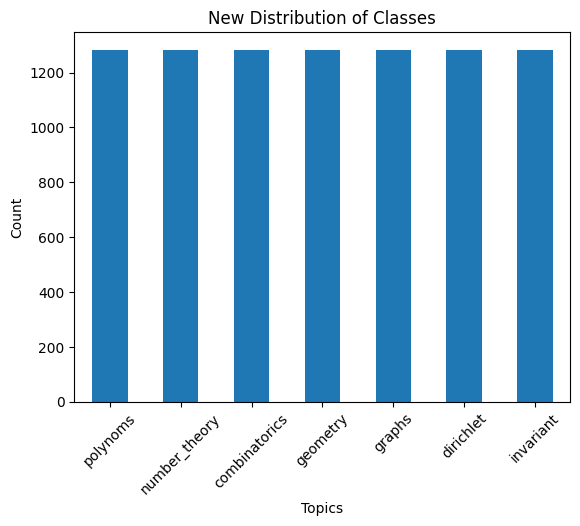

In [21]:
# Lets marvel at the augmeted train set
import matplotlib.pyplot as plt

class_counts = train_augmented['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [22]:
# There could be some duplicates creeping in after the augmetation
duplicates = train_augmented.duplicated(subset=['problem_text'], keep=False)

num_duplicates = duplicates.sum()

print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 2


In [23]:
!pip install transformers


In [24]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers.trainer_utils import EvalPrediction
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import os
import gc

# Set PYTORCH_CUDA_ALLOC_CONF
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Encode labels into integers
label_encoder = LabelEncoder()
train_augmented['labels'] = label_encoder.fit_transform(train_augmented['topic'])
val['labels'] = label_encoder.transform(val['topic'])
test['labels'] = label_encoder.transform(test['topic'])

# Проверка данных на наличие пропущенных значений и смешанных типов
train_augmented = train_augmented.dropna(subset=['problem_text'])
train_augmented['problem_text'] = train_augmented['problem_text'].astype(str)

val = val.dropna(subset=['problem_text'])
val['problem_text'] = val['problem_text'].astype(str)

test = test.dropna(subset=['problem_text'])
test['problem_text'] = test['problem_text'].astype(str)

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_augmented)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['problem_text'], padding="max_length", truncation=True, max_length=512) # надо уточнять! 

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])

# Define the number of classes
num_labels = len(label_encoder.classes_)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=num_labels)

# Define compute_metrics function
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    labels = torch.tensor(labels)
    accuracy = accuracy_score(labels.numpy(), predictions.numpy())
    precision = precision_score(labels.numpy(), predictions.numpy(), average='macro')
    recall = recall_score(labels.numpy(), predictions.numpy(), average='macro')
    f1 = f1_score(labels.numpy(), predictions.numpy(), average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Fixed hyperparameters based on the training results
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Increased number of epochs
    per_device_train_batch_size=8,  # Adjusted batch size
    per_device_eval_batch_size=4,
    warmup_steps=500,  # Increased warmup steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=5000,
    save_total_limit=2,
    learning_rate=2e-5,  # Adjusted learning rate
    gradient_accumulation_steps=2,
    fp16=False,
    dataloader_num_workers=4,
    gradient_checkpointing=False,
    max_grad_norm=0.5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(torch.optim.AdamW(model.parameters(), lr=2e-5), None),
    compute_metrics=compute_metrics
)

for name, param in model.named_parameters():
    if param.grad is not None:
        if has_nan_or_inf(param.grad):
            print(f"Gradient of {name} contains NaN or Inf.")
            break

# Train and evaluate the model
trainer.train()
evaluation = trainer.evaluate()

# Extract and print all metrics
accuracy = evaluation.get('eval_accuracy', 0)
precision = evaluation.get('eval_precision', 0)
recall = evaluation.get('eval_recall', 0)
f1 = evaluation.get('eval_f1', 0)

print(f"Final Accuracy: {accuracy}")
print(f"Final Precision: {precision}")
print(f"Final Recall: {recall}")
print(f"Final F1 Score: {f1}")



tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an 

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,1.887000
200,1.598300
300,1.276600
400,1.071400
500,0.940200
600,0.819900
700,0.686600
800,0.591600
900,0.556900
1000,0.530400


Final Accuracy: 0.7013888888888888
Final Precision: 0.5761904355012367
Final Recall: 0.5161110537271539
Final F1 Score: 0.5352543603314709


In [25]:
# Save the trained model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [26]:
print('done')

done


In [29]:
ls -la /kaggle/working/saved_model/model.safetensors

-rw-r--r-- 1 root root 711458836 May 19 16:39 /kaggle/working/saved_model/model.safetensors


In [30]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = '/kaggle/working/saved_model/model.safetensors'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/saved_model/model.safetensors

In [28]:
# очень долго работало, просто подсмотрел из вывода неплохтие параметры и сунул как оптимальные в ячейку для тренировки )
# the calculations were slooow and somwwhat buggy. I picked up some nice parameters I deemed optimised 
# and used them for the training in the cell right below 
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers.trainer_utils import EvalPrediction
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import gc
import os

# Set PYTORCH_CUDA_ALLOC_CONF
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

torch.autograd.set_detect_anomaly(True)


# Encode labels into integers
label_encoder = LabelEncoder()
train_augmented['labels'] = label_encoder.fit_transform(train_augmented['topic'])
val['labels'] = label_encoder.transform(val['topic'])
test['labels'] = label_encoder.transform(test['topic'])

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_augmented)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['problem_text'], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])

# Define the number of classes
num_labels = len(label_encoder.classes_)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=num_labels)

# Define compute_metrics function
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define objective function for Optuna
def objective(trial):
    torch.cuda.empty_cache()  # Clear GPU cache
    
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-4, log=True)
    # learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)  # Slightly increased min learning rate
    num_train_epochs = trial.suggest_int('num_train_epochs', 3, 10)
    per_device_train_batch_size = trial.suggest_int('per_device_train_batch_size', 2, 8)
    per_device_eval_batch_size = trial.suggest_int('per_device_eval_batch_size', 2, 8)
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.1, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 100, 1000)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)  # Tightened gradient clipping
    gradient_accumulation_steps = trial.suggest_int('gradient_accumulation_steps', 1, 4)  # Gradient accumulation steps

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=100,
        save_steps=5000,
        save_total_limit=2,
        learning_rate=learning_rate,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=True,
        dataloader_num_workers=4,
        gradient_checkpointing=False,
        max_grad_norm=max_grad_norm  # Gradient clipping
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        optimizers=(torch.optim.AdamW(model.parameters(), lr=learning_rate), None),
        compute_metrics=compute_metrics
    )

    def has_nan(tensor):
        return tensor is not None and torch.isnan(tensor).any().item()

    try:
        trainer.train()
        for name, param in model.named_parameters():
            if has_nan(param.grad):
                raise RuntimeError(f'Gradient of {name} contains NaN.')
        evaluation = trainer.evaluate()
        f1 = evaluation.get('eval_f1', 0)
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Out of memory error caught: {e}")
            return None
        elif "contains NaN" in str(e):
            print(f"NaN value detected in gradients: {e}")
            return None
        else:
            raise e
    finally:
        torch.cuda.empty_cache()
        gc.collect()

    return f1

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")

# Use the best hyperparameters to train the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_trial.params['num_train_epochs'],
    per_device_train_batch_size=best_trial.params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_trial.params['per_device_eval_batch_size'],
    warmup_steps=best_trial.params['warmup_steps'],
    weight_decay=best_trial.params['weight_decay'],
    logging_dir='./logs',
    logging_steps=100,
    save_steps=5000,
    save_total_limit=2,
    learning_rate=best_trial.params['learning_rate'],
    gradient_accumulation_steps=best_trial.params['gradient_accumulation_steps'],
    fp16=True,
    dataloader_num_workers=4,
    gradient_checkpointing=True,
    max_grad_norm=best_trial.params['max_grad_norm']
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(torch.optim.AdamW(model.parameters(), lr=best_trial.params['learning_rate']), None),
    compute_metrics=compute_metrics
)

trainer.train()
evaluation = trainer.evaluate()
f1 = evaluation.get('eval_f1', 0)

print(f"Final F1 Score with best hyperparameters: {f1}")


Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-05-19 16:39:38,631] A new study created in memory with name: no-name-2b881145-5b93-4aba-b7af-25070ec7d2fc
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
100,1.966300
200,1.938700
300,1.935300
400,1.937800
500,1.904100
600,1.892900
700,1.851700
800,1.833700
900,1.799000
1000,1.759500


[W 2024-05-19 17:02:09,476] Trial 0 failed with parameters: {'learning_rate': 5.696242345304639e-07, 'num_train_epochs': 9, 'per_device_train_batch_size': 5, 'per_device_eval_batch_size': 5, 'weight_decay': 0.0479827944463219, 'warmup_steps': 968, 'max_grad_norm': 0.19460211085128593, 'gradient_accumulation_steps': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/3433212379.py", line 111, in objective
    trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 1780, in train
    return inner_training_loop(
  File "/opt/conda/lib/python3.10/site-packages/transformers/trainer.py", line 2118, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs)
KeyboardInterrupt
[W 2024-05-19 17:02:09,478] Trial 0 failed with value None.

Keyboa